In [1]:
import numpy as np
import pandas as pd # Dùng để đọc và hiển thị file csv/tsv
import matplotlib.pyplot as plt
import plotly
import seaborn as sns

## Phần 1: Thu thập dữ liệu

Thu thập dữ liệu tập vgsale.csv từ kaggle<br>Link url: https://www.kaggle.com/mehulhyd/vgsales

## Phần 2: Khám phá dữ liệu (đủ để có thể xác định câu hỏi)

In [2]:
game_df = pd.read_csv('vgsales.csv')
game_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


### a/ Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
num_rows = len(game_df.index)
num_cols = len(game_df.columns)
print('Row: ', num_rows, '- Col: ', num_cols)

Row:  16598 - Col:  11


### b/ Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin của một game được sắp xếp theo hạng doanh thu, và có vẻ không có vấn đề các dòng có ý nghĩa khác nhau.

### c/ Dữ liệu có các dòng bị lặp không?

In [5]:
game_df.index.duplicated().sum()

0

### d/ Mỗi cột có ý nghĩa gì?

Mô tả ý nghĩa về các cột trong file "vgsale.csv":
- **Rank**: xếp hạng của các game
- **Name**: tên game
- **Platform**: tên hệ máy mà game hướng tới
- **Year**: năm phát hành
- **Genre**: thể loại game
- **Publisher**: nhà sản xuất game
- **NA_Sales**: Số lượng bản bán ra của khu vực Bắc Mỹ
- **EU_Sales**: Số lượng bản bán ra của khu vực Châu Âu
- **JP_Sales**: Số lượng bản bán ra của khu vực Nhật Bổn
- **Other_Sales**: Số lượng bản bán ra của các khu vực khác
- **Global_Sales**: Số lượng bản bán ra của toàn thế giới.

### e/ Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [6]:
col_dtypes = pd.Series(game_df.dtypes.values, index=game_df.dtypes.axes)
col_dtypes

Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

**Cột có dtype là object nghĩa là sao?**

In [7]:
def open_object_dtype(s, name):
    dtypes = set()
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    if s.dtype == object:
        dtypes = s.apply(lambda x: type(x))
    
    print(name + ': ', set(dtypes))
    
open_object_dtype(game_df['Name'], 'Name')
open_object_dtype(game_df['Genre'], 'Genre')
open_object_dtype(game_df['Publisher'], 'Publisher')

Name:  {<class 'str'>}
Genre:  {<class 'str'>}
Publisher:  {<class 'str'>, <class 'float'>}


Như vậy các cột object đa số đều là chuỗi và đều hợp với lại chức năng của nó chỉ riêng cột publisher có kèm số float vào vậy điều đầu tiên nghĩ tới là rất có thể cột này bị thiếu giá trị dữ liệu

**Kiểm tra giá trị thiếu của các cột**

In [8]:
game_df.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

Quả đúng như vậy và kèm theo ở trên thì các vấn đề cần tiền xử lý đó là:<br>+ Bổ sung các giá trị còn thiếu.<br>+ Đổi kiểu cột year sang int<br><br>Đối với việc xử lý giá trị thiếu thì:<br>+ Cột Year: dựa theo cột Platform thay năm xuất hiện nhiều nhất đối với platform đó<br>+ Cột Publisher: dựa theo cột Genre để điền<br><br>**Tiền xử lý dữ liệu**

In [9]:
def fill_missing(key1, key2):
    missing_df = game_df[game_df[key1].isna()]
    missing = list(set(game_df[game_df[key1].isna()][key2]))
    
    temp = game_df[[key1, key2]].dropna().value_counts().reset_index().rename(columns={0 : 'Counts'})
    
    filling = list()

    for p in missing:
        filling.append(temp[temp[key2] == p].reset_index()[key1][0])
        
    for i in range(len(missing)):
        missing_df.loc[missing_df[key2] == missing[i], key1] = filling[i]

    game_df.loc[missing_df.index] = missing_df.loc[missing_df.index]
    
fill_missing('Publisher', 'Genre')
fill_missing('Year', 'Platform')

/home/katakuri_v/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/katakuri_v/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
game_df['Year'] = game_df['Year'].astype(int)
game_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


**Phân loại dạng kiểu dữ liệu**

In [11]:
game_df.nunique()

Rank            16598
Name            11493
Platform           31
Year               39
Genre              12
Publisher         578
NA_Sales          409
EU_Sales          305
JP_Sales          244
Other_Sales       157
Global_Sales      623
dtype: int64

Nhìn vào số lượng giá trị khác nhau ở trên thì có thể dễ dàng nhận thấy được có 2 cột numeric là Year và Genre. Còn lại là category

In [12]:
nume_col = ['Rank', 'Name', 'Year', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
nume_col_profiles_df = pd.DataFrame(columns=nume_col, index=['missing_ratio', 'min', 'max'])
nume_col_profiles_df.loc['missing_ratio'] = pd.to_numeric((len(game_df[nume_col]) - game_df[nume_col].count()) / len(game_df[nume_col]) * 100, downcast="float")
nume_col_profiles_df.loc['min'] = game_df[nume_col].min()
nume_col_profiles_df.loc['max'] = game_df[nume_col].max()
nume_col_profiles_df[nume_col[0:len(nume_col)]] = nume_col_profiles_df[nume_col[0:len(nume_col)]].apply(pd.to_numeric, errors='coerce')
nume_col_profiles_df

,Rank,Name,Year,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
missing_ratio,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
min,1.0,NaN,1980.0,NaN,0.00,0.00,0.00,0.00,0.01
max,16600.0,NaN,2020.0,NaN,41.49,29.02,10.22,10.57,82.74


In [13]:
cate_col = ['Year', 'Genre']
cate_col_profiles_df = pd.DataFrame(columns=cate_col, index=['missing_ratio', 'num_diff_vals', 'diff_vals'])
cate_col_profiles_df.loc['missing_ratio'] = pd.to_numeric((len(game_df[cate_col]) - game_df[cate_col].count()) / len(game_df[cate_col]) * 100, downcast="float")
cate_col_profiles_df.loc['num_diff_vals'] = game_df[cate_col].apply(lambda x: x.value_counts().count())
cate_col_profiles_df.loc['diff_vals'] = game_df[cate_col].apply(lambda x: x.value_counts().index)
cate_col_profiles_df

,Year,Genre
missing_ratio,0.0,0.0
num_diff_vals,39,12
diff_vals,"Int64Index([2009, 2008, 2010, 2011, 2007, 2006...","Index(['Action', 'Sports', 'Misc', 'Role-Playi..."


## Phần 3: Đưa ra các câu hỏi cần trả lời

Sau khi đã khám phá dữ liệu và hiểu hơn về dữ liệu, em chia ra các vấn đề theo thời gian để trực quan hóa:
- Tình hình quá khứ và hiện tại:
<br> - Sự phát triển của các khu vực qua từng giai đoạn, nơi đâu là mảnh đất béo bở cho ngành công nghiệp game ?
<br> - Xu hướng thể loại game hay platform thay đổi thế nào theo thời gian ?.
<br> - Thể loại game nào được chơi hệ máy nào được yêu thích khi liên tục được phát triển trong suốt các giai đoạn?
<br> - Tìm mối tương quan về sự lan rộng của game trên toàn thế giới với sự khởi đầu là Nhật
- Xu hướng phát triển cho tương lai:

## Phần 4: Trực quan hóa dữ liệu để trả lời các câu hỏi

### 1.Sự phát triển của các khu vực qua từng giai đoạn,Nơi đâu là mảnh đất béo bở cho ngành công nghiệp game

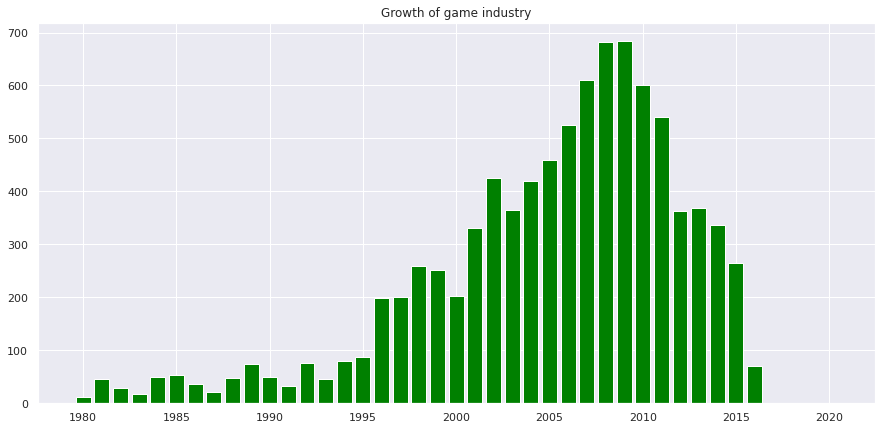

In [14]:
growth = game_df[["Year","NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"]].groupby("Year").sum()
sns.set(rc={'figure.figsize':(15,7)})
plt.bar(growth.index,growth["Global_Sales"],color = "green",label = "Global_Sales")
plt.title("Growth of game industry");

-Game lần đầu tiên xuất hiện vào năm 1952

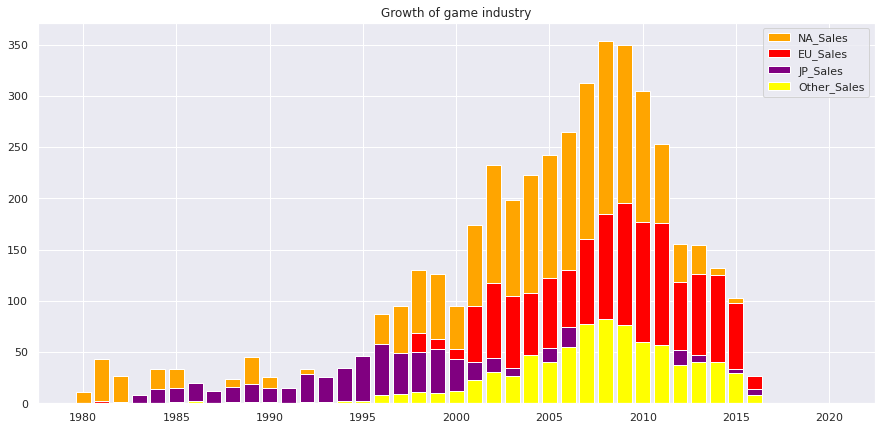

In [15]:
plt.bar(growth.index,growth["NA_Sales"],color = "orange",label = "NA_Sales")
plt.bar(growth.index,growth["EU_Sales"],color = "red",label = "EU_Sales")
plt.bar(growth.index,growth["JP_Sales"],color = "purple",label = "JP_Sales")
plt.bar(growth.index,growth["Other_Sales"],color = "yellow",label = "Other_Sales")
plt.legend()
plt.title("Growth of game industry");

In [16]:
t1 = game_df[["Year","Genre","Global_Sales"]].groupby(["Year","Genre"]).sum().unstack(0).idxmax()
t2 = game_df[["Year","Genre","Global_Sales"]].groupby(["Year","Genre"]).sum().groupby(["Year"]).max()
t1.reset_index(level = 0,inplace = True,drop = True)
t1.name="Genre"
t2.name="Sales"
best_genre_overtime = pd.concat([t1, t2], axis=1)
best_genre_overtime.head()

,Genre,Global_Sales
Year,,
1980,Shooter,7.07
1981,Action,17.79
1982,Puzzle,10.03
1983,Platform,6.93
1984,Shooter,31.10


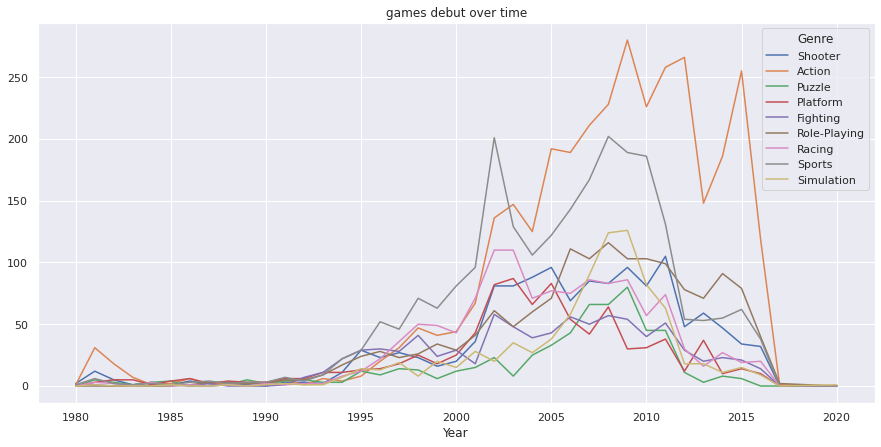

In [17]:
b_genres = best_genre_overtime["Genre"].unique()
games_db = game_df[["Year","Genre","Name"]].groupby(["Year","Genre"]).size().unstack(1).fillna(0)
games_db[b_genres].plot(figsize = (15,7))
plt.title("games debut over time");

<AxesSubplot:xlabel='Genre', ylabel='Year'>

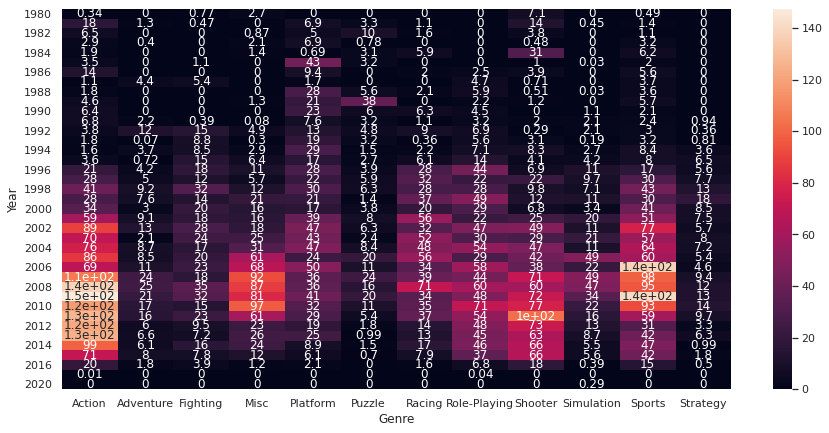

In [18]:
games_sale = game_df[["Year","Genre","Global_Sales"]].groupby(["Year","Genre"]).sum().unstack(1).fillna(0)
games_sale.columns = games_sale.columns.droplevel(0)
sns.heatmap(games_sale, annot=True)

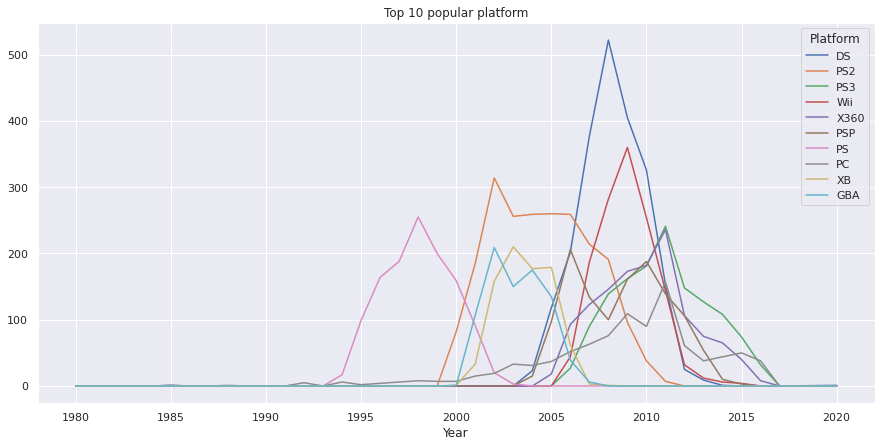

In [19]:
plat_db = game_df[["Year","Platform","Name"]].groupby(["Year","Platform"]).size().unstack(1).fillna(0)
top_plat = plat_db.sum(axis=0).sort_values(axis=0, ascending=False).head(10).index
plat_db[top_plat].plot(figsize = (15,7))
plt.title("Top 10 popular platform");

In [20]:
game_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


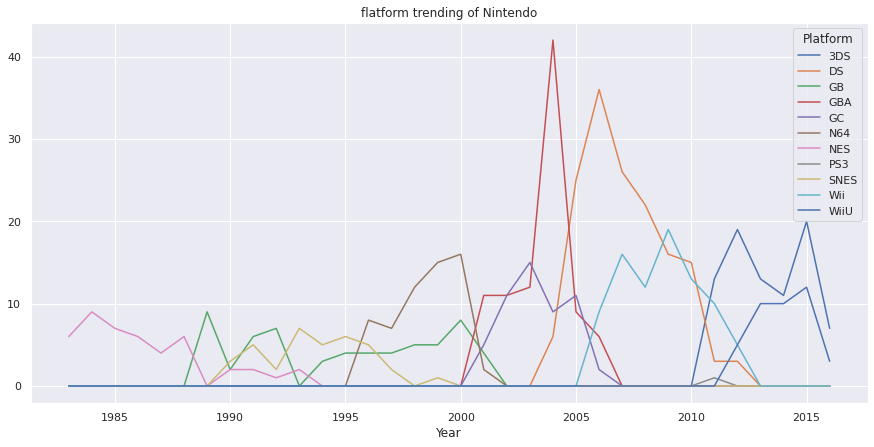

In [21]:
nintendo = game_df[game_df["Publisher"] == "Nintendo"]
nintendo = nintendo[["Year","Platform","Name"]].groupby(["Year","Platform"]).size().unstack(1).fillna(0)
nintendo.plot(figsize = (15,7))
plt.title("flatform trending of Nintendo");